<a href="https://colab.research.google.com/github/JenBanks8585/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/Jen_Banks__LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train_orig = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test_orig = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [0]:
# Split train data set
train=train_orig.copy()
test=test_orig.copy()

train, val = train_test_split(train, test_size=0.2)

In [0]:
# Data Wranggling

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 6.1% of 'funder' cell are missing, fill with mode
    X['funder']=X['funder'].fillna(X.funder.mode()[0], inplace=False)

    # About 6.2% of 'installer' cell are missing, fill with mode
    X['installer']=X['installer'].fillna(X['installer'].mode()[0], inplace=False)

    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

     # About 5.7% of 'public_meeting' cell are missing, fill with mode
    X['public_meeting']=X['public_meeting'].fillna(X['public_meeting'].mode()[0],
                                                   inplace=False)

    # About 6.5% of 'public_meeting' cell are missing, fill with mode
    X['scheme_management']=X['scheme_management'].fillna(X['scheme_management'].mode()[0],
                                                         inplace=False)
    
    # About 5.2% of 'public_meeting' cell are missing, fill with mode
    X['permit']=X['permit'].fillna(X['permit'].mode()[0], inplace=False)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [79]:
#using RandomForest, ordinal encoding

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve


pipeline_rf_ord=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

depth =range( 1, 30, 3)
train_scores, val_scores=validation_curve(
    pipeline_rf_ord, X_train,y_train,
    param_name='randomforestclassifier__max_depth',
    param_range=depth, scoring='accuracy',
    cv= 3,
    n_jobs=-1
)

pipeline_rf_ord.fit(X_train, y_train)
print(pipeline_rf_ord.score(X_train, y_train))
print(pipeline_rf_ord.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.9978114478114478
0.803030303030303


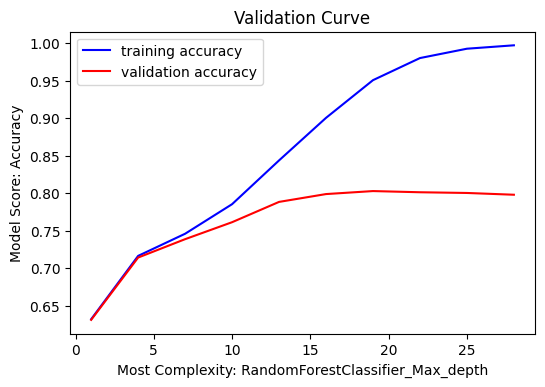

In [80]:
# Plotting Validation Curve with RandomForest, max depth Hyperparameter

plt.figure(dpi=100)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(depth, np.mean(val_scores, axis= 1), color='red', label= 'validation accuracy')
plt.title('Validation Curve')
plt.xlabel('Most Complexity: RandomForestClassifier_Max_depth')
plt.ylabel('Model Score: Accuracy')
plt.legend();

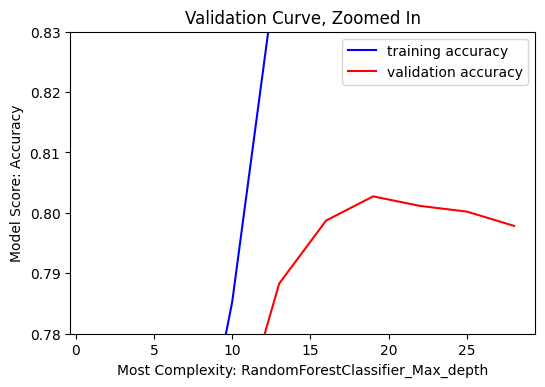

In [84]:
#Zooming In

plt.figure(dpi=100)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(depth, np.mean(val_scores, axis= 1), color='red', label= 'validation accuracy')
plt.title('Validation Curve, Zoomed In')
plt.xlabel('Most Complexity: RandomForestClassifier_Max_depth')
plt.ylabel('Model Score: Accuracy')
plt.ylim(0.78, 0.83)
plt.legend();

In [0]:
# Creating a prediction file

y_pred_rf_ord=pipeline_rf_ord.predict(X_test)
submission_rf_ord=sample_submission.copy()
submission_rf_ord['status_group']=y_pred_rf_ord
submission_rf_ord.to_csv('submission_rf_ord.csv', index=False)

In [86]:
# Using Bagging ensemble, no replacement
from sklearn.tree import DecisionTreeClassifier

pipeline_bag1=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=100,
                      max_features=0.6, 
                      max_samples=0.4, 
                      bootstrap=False, 
                      bootstrap_features= False)
)

feat =[ 0.3, .5, 0.8]
train_scores, val_scores=validation_curve(
    pipeline_bag1, X_train,y_train,
    param_name='baggingclassifier__max_features',
    param_range=feat, scoring='accuracy',
    cv= 3,
    n_jobs=-1
)

pipeline_bag1.fit(X_train, y_train)
print(pipeline_bag1.score(X_train, y_train))
print(pipeline_bag1.score(X_val, y_val))

0.955324074074074
0.8141414141414142


In [0]:
# Creating a prediction file

y_pred_bag1=pipeline_bag1.predict(X_test)
submission_bag1=sample_submission.copy()
submission_bag1['status_group']=y_pred_bag1
submission_bag1.to_csv('submission_bag811.csv', index=False)

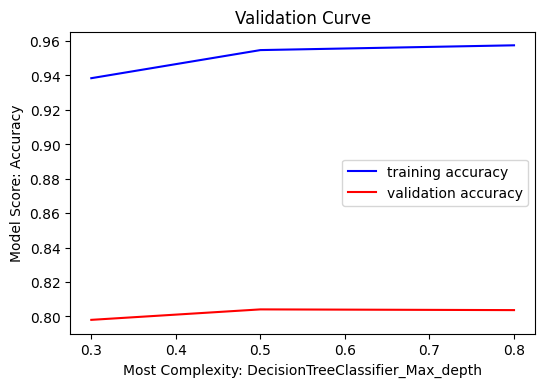

In [41]:
# Plotting Validation Curve with DecisioonTreeClassifier, max_features Hyperparameter

plt.figure(dpi=100)
plt.plot(feat, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(feat, np.mean(val_scores, axis= 1), color='red', label= 'validation accuracy')
plt.title('Validation Curve')
plt.xlabel('Most Complexity: DecisionTreeClassifier_Max_depth')
plt.ylabel('Model Score: Accuracy')
plt.legend();

###Using RandomizedSearchCV

In [89]:
#With RandomizedSearchCV on RandomforestClassifier

pipeline_rf_rand=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

param_distribution={
    'simpleimputer__strategy':['mean','most_frequent', 'median'],
    'randomforestclassifier__max_depth':[3,5,10],
    'randomforestclassifier__n_estimators':[10,20,30],
    'randomforestclassifier__criterion':['gini', 'entropy']
}

search=RandomizedSearchCV(
    pipeline_rf_rand,
    param_distributions=param_distribution,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    verbose=10,
    n_jobs=-1
)

search.fit(X_train, y_train)
print(search.score(X_train, y_train))
print(search.score(X_val, y_val))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


0.7823863636363636
0.7718855218855218


In [90]:
print("Best Parameters", search.best_params_)
print("Best Accuracy score", search.best_score_)

Best Parameters {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 30, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'gini'}
Best Accuracy score 0.7621843434343435


In [103]:
pipeline_rf_rand_sample=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators= 30,
                           max_depth=10, 
                           criterion='gini')
)

pipeline_rf_rand_sample.fit(X_train, y_train)
print(pipeline_rf_rand_sample.score(X_train, y_train))
print(pipeline_rf_rand_sample.score(X_val, y_val))

0.7805765993265993
0.7668350168350169


In [0]:
# Creating a prediction file

y_pred_rf_rand=search.predict(X_test)
submission_rf_rand=sample_submission.copy()
submission_rf_rand['status_group']=y_pred_rf_rand
submission_rf_rand.to_csv('submission_rf_rand.csv', index=False)


In [69]:
#With RandomizedSearchCV on BaggingClassifier

pipeline_bag_rand=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    BaggingClassifier()
)

param_distribution={
    'simpleimputer__strategy':['mean','most_frequent', 'median'],
    'baggingclassifier__max_features':[.3,.5,1.0],
    'baggingclassifier__n_estimators':[30,50,1000],
    'baggingclassifier__bootstrap':[False, True]
}

search1=RandomizedSearchCV(
    pipeline_bag_rand,
    param_distributions=param_distribution,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    verbose=10,
    n_jobs=-1
)

search1.fit(X_train, y_train)
print(search1.score(X_train, y_train))
print(search1.score(X_val, y_val))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 61.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 63.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 69.7min finished


0.9970538720538721
0.8103535353535354


In [93]:
print("Best Parameters", search1.best_params_)
print("Best Accuracy score", search1.best_score_)

Best Parameters {'simpleimputer__strategy': 'mean', 'baggingclassifier__n_estimators': 1000, 'baggingclassifier__max_features': 0.5, 'baggingclassifier__bootstrap': True}
Best Accuracy score 0.8017255892255891


In [0]:
# Creating a prediction file

y_pred_bag_rand=search1.predict(X_test)
submission_bag_rand=sample_submission.copy()
submission_bag_rand['status_group']=y_pred_bag_rand
submission_bag_rand.to_csv('submission_bag_rand.csv', index=False)

In [123]:
# Checking for detailed report
import pandas as pd

pd.DataFrame(search1.cv_results_).sort_values(by='rank_test_score').T

,12,7,17,16,14,18,3,10,13,19,4,11,0,6,8,5,2,9,15,1
mean_fit_time,234.96,12.4711,13.7694,9.36941,9.06797,120.847,127.832,15.1694,16.4866,15.5453,19.8035,11.7525,203.728,201.922,4.60523,12.3363,5.88444,762.332,23.9827,760.23
std_fit_time,3.51609,0.142497,0.255716,2.14668,0.0782349,12.1952,2.38515,0.0479789,0.0501591,0.0657446,0.97971,0.278648,1.3347,1.89149,0.257439,0.450437,0.261378,8.95579,0.307505,7.26221
mean_score_time,6.78457,0.523981,0.590185,0.409925,0.421611,5.77704,5.93874,0.439659,0.467917,0.462623,0.597083,0.405189,6.73629,7.80371,0.373124,0.555446,0.380798,9.32891,0.46744,9.14584
std_score_time,0.280536,0.00763606,0.0195281,0.0158766,0.00248624,0.813815,0.169667,0.00259622,0.00768959,0.0129214,0.017404,0.00414121,0.147568,1.50569,0.00756143,0.0380035,0.0033627,0.348414,0.015494,0.351406
param_simpleimputer__strategy,mean,mean,most_frequent,mean,most_frequent,most_frequent,median,median,most_frequent,mean,most_frequent,median,median,most_frequent,mean,most_frequent,most_frequent,most_frequent,median,median
param_baggingclassifier__n_estimators,1000,50,50,30,30,1000,1000,30,30,30,50,30,1000,1000,30,50,30,1000,30,1000
param_baggingclassifier__max_features,0.5,0.5,0.5,0.5,0.5,0.3,0.3,1,1,1,0.5,0.5,0.3,0.3,0.3,0.3,0.3,1,1,1
param_baggingclassifier__bootstrap,True,True,True,True,True,True,True,True,True,True,False,False,False,False,True,False,True,False,False,False
params,"{'simpleimputer__strategy': 'mean', 'baggingcl...","{'simpleimputer__strategy': 'mean', 'baggingcl...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'mean', 'baggingcl...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'median', 'bagging...","{'simpleimputer__strategy': 'median', 'bagging...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'mean', 'baggingcl...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'median', 'bagging...","{'simpleimputer__strategy': 'median', 'bagging...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'mean', 'baggingcl...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'median', 'bagging...","{'simpleimputer__strategy': 'median', 'bagging..."
split0_test_score,0.802146,0.794444,0.800189,0.794192,0.79596,0.792045,0.792361,0.792614,0.792614,0.790783,0.785732,0.792487,0.784091,0.785606,0.773548,0.779924,0.770013,0.74375,0.743182,0.741982


In [102]:
#With RandomizedSearchCV on RandomForestClassifier with function
from xgboost.sklearn import XGBClassifier

classifier=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

params={
    'simpleimputer__strategy':['mean','most_frequent', 'median'],
    'randomforestclassifier__min_samples_leaf':[3,5,10],
    'randomforestclassifier__n_estimators':[50,100],
    'randomforestclassifier__criterion':['gini', 'entropy']
}

def hypertuning(classifier, param_dist, n_iters, X,y ):
    search2=RandomizedSearchCV(
        classifier,
        param_distributions=param_dist,
        n_jobs=-1,
        n_iter=n_iters,
        verbose=10,
        cv=3)
    search2.fit(X_train, y_train)
    hyper_params=search2.best_params_
    hyper_score=search2.best_score_
    return hyper_params, hyper_score

hyper_params, hyper_score=hypertuning(classifier, params, 5, X_train,y_train)

hyper_params, hyper_score

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


({'randomforestclassifier__criterion': 'entropy',
  'randomforestclassifier__min_samples_leaf': 3,
  'randomforestclassifier__n_estimators': 50,
  'simpleimputer__strategy': 'median'},
 0.7999999999999999)

In [108]:
# Applying the given hyperparameters

classifier2=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy= 'median'),
    RandomForestClassifier(criterion='entropy',
                           min_samples_leaf= 3,
                           n_estimators=50)
)

classifier2.fit(X_train, y_train)
print(classifier2.score(X_train, y_train))
print(classifier2.score(X_val, y_val))

0.8926767676767676
0.813047138047138


In [0]:
# Creating a prediction file

y_pred_rf_func=classifier2.predict(X_test)
submission_rf_func=sample_submission.copy()
submission_rf_func['status_group']=y_pred_rf_func
submission_rf_func.to_csv('submission_rf_rand.csv', index=False)

In [99]:
#With RandomizedSearchCV on XGBoost with function

pipeline_xgb=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    XGBClassifier(n_estimators=50)
)

params_xgb={
    'simpleimputer__strategy':['mean','most_frequent', 'median'],
    'xgbclassifier__min_child_weight':[1,5,10],
    'xgbclassifier__max_depth':[5,10, 15],
    'xgbclassifier__learning_rate':[0.3, 0.5, 1.0],
    'xgbclassifier__scale_pos_weight':[0.5,1],
}


hyper_params, hyper_score=hypertuning(pipeline_xgb, params_xgb, 5, X_train,y_train)

hyper_params, hyper_score


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.9min finished


({'simpleimputer__strategy': 'most_frequent',
  'xgbclassifier__learning_rate': 0.3,
  'xgbclassifier__max_depth': 10,
  'xgbclassifier__min_child_weight': 1,
  'xgbclassifier__scale_pos_weight': 0.5},
 0.8003998316498316)

In [100]:
#Applying hyperparameters

pipeline_xgb_sample=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    XGBClassifier(n_estimators=50, learning_rate=.3, max_depth= 10, min_child_weight=1, scale_pos_weight= 0.5)
)

pipeline_xgb_sample.fit(X_train, y_train)
print(pipeline_xgb_sample.score(X_train, y_train))
print(pipeline_xgb_sample.score(X_val, y_val))

0.9070286195286196
0.8104377104377104


In [0]:
# Creating a prediction file

y_pred_xgb_func=pipeline_xgb_sample.predict(X_test)
submission_xgb_func=sample_submission.copy()
submission_xgb_func['status_group']=y_pred_xgb_func
submission_xgb_func.to_csv('submission_xgb_rand.csv', index=False)

In [0]:
#Creating a csv file for sample submission

sample_submission.to_csv('sample_submission.csv', index=False)

In [0]:
# Stacking

import pandas as pd
 
# Filenames of your submissions you want to ensemble
files = ['submission_rf_ord.csv', 'submission_bag811.csv', 'submission_bag_rand.csv', 'submission_rf_rand.csv', 'submission_xgb_rand.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]
 
sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)

In [118]:
# Stacking data, the mode/observation will be final prediction

ensemble

,status_group,status_group,status_group,status_group,status_group
0,functional,functional,functional,non functional,non functional
1,functional,functional,functional,functional,functional
2,functional,functional,functional,functional,functional
3,non functional,non functional,non functional,non functional,non functional
4,functional,functional,functional,functional,functional
...,...,...,...,...,...
14353,non functional,non functional,non functional,non functional,non functional
14354,functional,functional,functional,functional,functional
14355,functional,functional,functional,functional,functional
14356,functional,functional,functional,functional,functional


###Applying the highest score to the whole TRAIN dataset

In [0]:
#Copying and wrangling data

train_whole=train_orig.copy()
test_whole=test_orig.copy()

train_whole = wrangle(train_whole)
test_whole = wrangle(test_whole)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features2 = train_whole.drop(columns=[target])

# Get a list of the numeric features
numeric_features2 = train_features2.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality2 = train_features2.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features2 = cardinality2[cardinality2 <= 50].index.tolist()

# Combine the lists 
features2 = numeric_features2 + categorical_features2

In [0]:
# Arrange data into X features matrix and y target vector 
X_train_whole = train_whole[features2]
y_train_whole = train_whole[target]
X_test_whole = test_whole[features2]

In [129]:
# Applying the given hyperparameters

classifier_whole=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy= 'median'),
    RandomForestClassifier(criterion='entropy',
                           min_samples_leaf= 3,
                           n_estimators=50)
)

classifier_whole.fit(X_train_whole, y_train_whole)
print(classifier_whole.score(X_train_whole, y_train_whole))


0.8925084175084175


In [0]:
y_pred_whole=classifier_whole.predict(X_test_whole)
submission_whole=sample_submission.copy()
submission_whole['status_group']=y_pred_whole
submission_whole.to_csv('submission_whole.csv', index=False)